In [1]:
import os
from typing import Dict, List, TypedDict, Annotated
from langgraph.graph import StateGraph, END,START
from langchain_core.messages import HumanMessage, AIMessage
from langchain_core.tools import tool
import requests
from langchain_core.prompts import ChatPromptTemplate
from dotenv import load_dotenv
from langchain_groq import ChatGroq
load_dotenv()
import arxiv

In [25]:
# Define the state for the graph
class State(TypedDict):
    messages: Annotated[List[HumanMessage | AIMessage], "The chat history"]

# Define the search tool 

@tool
def search_arxiv(query:str,max_results:int=3) -> List[Dict]:
    """Search research papers on Arxiv based on a given query"""
    client = arxiv.Client()
    search = arxiv.Search(
        query = query,
        max_results=max_results,
        sort_by = arxiv.SortCriterion.Relevance
    )

    try:
        results = client.results(search)
        papers = []
        for result in results:
            papers.append({
                "title": result.title,
                "abstract": result.summary,
                "authors": [author.name for author in result.authors],
                "published": result.published.strftime("%Y-%m-%d"),
                "url": result.pdf_url
            })
        return papers
    except Exception as e:
        return f"Error searching Arxiv: {e}"


In [26]:
# Initialize the LLM
llm = ChatGroq(model="llama3-70b-8192")

# Define the prompt template
prompt = ChatPromptTemplate.from_messages([
    ("system", """You are a helpful AI assistant capable of answering general questions and searching for research papers on arXiv. Only use the search_arxiv tool when the user explicitly asks to search for research papers (e.g., phrases like 'search for papers,' 'find papers,' or 'look up research on'). For all other questions, including general inquiries about a topic, provide a concise and relevant response without using the tool."""),
    ("placeholder", "{messages}")
])


llm_with_tools = llm.bind_tools([search_arxiv])

model = prompt | llm_with_tools

In [27]:
def llm_node(state:State) -> State:
    messages = state["messages"]
    response = model.invoke(state)
    return {"messages":messages+[response]}

def tool_node(state: State)->State:
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        tool_call = last_message.tool_calls[0]
        if tool_call["name"] == "search_arxiv":
            results = search_arxiv.invoke(tool_call["args"])
            tool_response = AIMessage(
                content = f"Found {len(results)} papers:\n" + "\n".join(
                    [f"**Title:** {paper['title']}\n"
                    f"**Authors:** {', '.join(paper['authors'])}\n"
                    f"**Published:** {paper['published']}\n"
                    f"**Abstract:** {paper['abstract']}\n"
                    f"**PDF:** {paper['url']}\n"
                    for paper in results]
                )
            )
            return {"messages":messages+[tool_response]}
    return state


def should_call_tool(state:State) -> str:
    last_message = state["messages"][-1]
    if last_message.tool_calls:
        return "tools"
    return "end"


In [33]:
#Building the graph
workflow = StateGraph(State)

# Add nodes
workflow.add_node("llm",llm_node)
workflow.add_node("tools",tool_node)

# Add edges
workflow.add_edge(START,"llm")
workflow.add_conditional_edges(
    "llm",
    should_call_tool,
    {
        "tools": "tools",
        "end" : END
    }
)

workflow.add_edge("tools", END)

graph = workflow.compile()

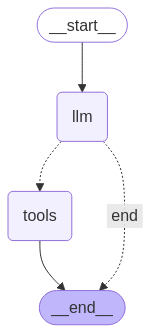

In [34]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [35]:
def run_conversation(user_input:str, state:State=None):
    if state is None:
        state = {"messages": []}
    state["messages"].append(HumanMessage(content=user_input))
    result = graph.invoke(state)
    return result,result["messages"][-1].content

In [42]:
state = None
state,response = run_conversation("what is the weather in Tokyo?",state)
print(response)

The current weather in Tokyo is not provided, but I can give you a general idea of Tokyo's climate. Tokyo has a humid subtropical climate with four distinct seasons. The summer months (June to August) are hot and humid, with temperatures often reaching over 30°C (86°F). The winter months (December to February) are cool, with temperatures ranging from 0°C to 10°C (32°F to 50°F). Spring (March to May) and autumn (September to November) are mild and comfortable, with temperatures between 10°C to 20°C (50°F to 68°F).


In [43]:
state,response = run_conversation("What is machine learning?",state)
print(response)

Machine learning is a subfield of artificial intelligence that involves using algorithms and statistical models to enable machines to learn from data, make decisions, and improve their performance on a task without being explicitly programmed. In other words, machine learning allows systems to automatically improve their performance on a task by learning from experience and adapting to new data. This is achieved by identifying patterns in data and making predictions or decisions based on that data. Machine learning has numerous applications, including image and speech recognition, natural language processing, recommender systems, and predictive analytics.


In [45]:
state,response = run_conversation("Give me some papers on machine learning",state)
print(response)

Found 5 papers:
**Title:** Lecture Notes: Optimization for Machine Learning
**Authors:** Elad Hazan
**Published:** 2019-09-08
**Abstract:** Lecture notes on optimization for machine learning, derived from a course at
Princeton University and tutorials given in MLSS, Buenos Aires, as well as
Simons Foundation, Berkeley.
**PDF:** http://arxiv.org/pdf/1909.03550v1

**Title:** An Optimal Control View of Adversarial Machine Learning
**Authors:** Xiaojin Zhu
**Published:** 2018-11-11
**Abstract:** I describe an optimal control view of adversarial machine learning, where the
dynamical system is the machine learner, the input are adversarial actions, and
the control costs are defined by the adversary's goals to do harm and be hard
to detect. This view encompasses many types of adversarial machine learning,
including test-item attacks, training-data poisoning, and adversarial reward
shaping. The view encourages adversarial machine learning researcher to utilize
advances in control theory and re

In [36]:
state=None

while True:
    user_input = input("You: ")
    if user_input.lower() in ["quite","exit"]:
        break 
    state,response = run_conversation(user_input,state)
    print(response)

A black hole is a region in space where the gravitational pull is so strong that nothing, including light, can escape. It is formed when a massive star collapses in on itself and its gravity becomes so strong that it warps the fabric of spacetime around it. The point of no return, called the event horizon, marks the boundary of the black hole, and once something crosses the event horizon, it is trapped forever. Black holes come in various sizes, ranging from small, stellar-mass black holes formed from the collapse of individual stars, to supermassive black holes found at the centers of galaxies, with masses millions or even billions of times that of the sun.


In [37]:
state

{'messages': [HumanMessage(content='What is a black hole?', additional_kwargs={}, response_metadata={}),
  AIMessage(content='A black hole is a region in space where the gravitational pull is so strong that nothing, including light, can escape. It is formed when a massive star collapses in on itself and its gravity becomes so strong that it warps the fabric of spacetime around it. The point of no return, called the event horizon, marks the boundary of the black hole, and once something crosses the event horizon, it is trapped forever. Black holes come in various sizes, ranging from small, stellar-mass black holes formed from the collapse of individual stars, to supermassive black holes found at the centers of galaxies, with masses millions or even billions of times that of the sun.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 136, 'prompt_tokens': 1021, 'total_tokens': 1157, 'completion_time': 0.418900566, 'prompt_time': 0.063617306, 'queue_time': 1.0